In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [2]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

In [3]:
# merger.convert_deaths_df()
df = merger.merge_deaths_df()

/opt/conda/lib/python3.7/site-packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


In [4]:
df.tail()

,Sorszám,Nem,Kor,Alapbetegségek,date
4667,5,F,68,szív és érrendszeri,2020-11-29
4668,4,F,79,szív és érrendszeri,2020-11-29
4669,3,F,74,szív és érrendszeri,2020-11-29
4670,2,N,65,rosszindulatú daganat,2020-11-29
4671,1,N,76,szív és érrendszeri,2020-11-29


In [5]:
df_additional = merger.df["details"][["date","additional.infected"]].set_index("date")

In [6]:
df_tests = merger.show_kpi_hu()[["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

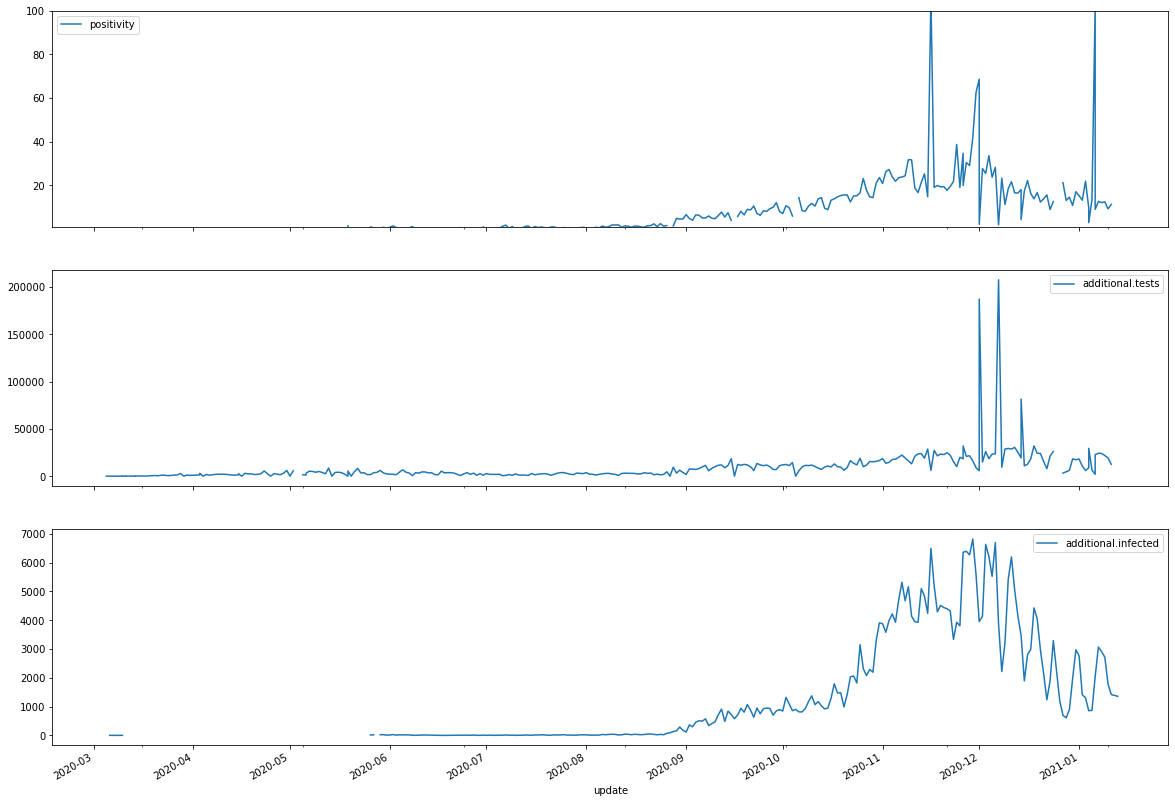

In [7]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,100)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

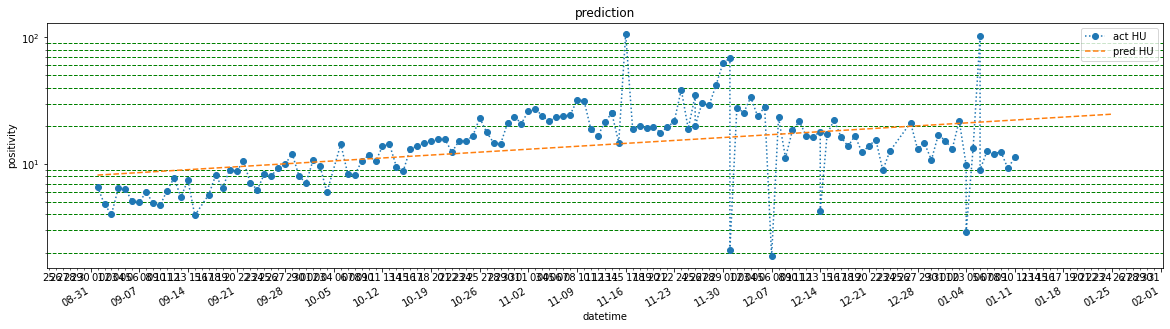

Coefficient of determination: {'HU': 0.18811571536891847}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
351,2021-01-08,2798939.0,24024.0,2907.0,12.100400,HU,2021-01-08
352,2021-01-09,2820762.0,21823.0,2716.0,12.445585,HU,2021-01-09
353,2021-01-10,2840024.0,19262.0,1778.0,9.230609,HU,2021-01-10
354,2021-01-11,2852591.0,12567.0,1419.0,11.291478,HU,2021-01-11
355,2021-01-13,2879364.0,NaN,1358.0,NaN,HU,2021-01-13


In [8]:
tmpDf = md.DataProcessing.Analyse.start_analyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()

# Check plausibility

In [9]:
# Details
selected_details_df = merger.df["details"][[
    "date", "additional.infected", "additional.deaths", 
    "cumulated.infected", "cumulated.recoveredFromHospital", 
    "onVentilator", "hospital", "active.infected"
]].copy()
selected_details_df.columns = [
    "date", "news.add.infected", "news.add.deaths", 
    "news.cum.infected", "news.cum.recovered", 
    "news.onVentilator", "news.hospital", "news.active"
]
selected_details_df["date"] = pd.to_datetime(selected_details_df["date"], format='%Y-%m-%d').dt.date
selected_details_df["news.add.recovered"] = selected_details_df.apply(
    lambda row: row["news.cum.recovered"] - selected_details_df[
        selected_details_df["date"]<row["date"]
    ]["news.cum.recovered"].max(), axis=1
)
selected_details_df = selected_details_df.set_index("date")

# KPI
selected_kpi_df = merger.show_kpi_hu()[["infected"]].copy().reset_index()
selected_kpi_df.columns = ["date", "kpi.cum.infected"]
selected_kpi_df["date"] = pd.to_datetime(selected_kpi_df["date"], format='%Y-%m-%d').dt.date
selected_kpi_df = selected_kpi_df.set_index("date")

selected_details_df.join(selected_kpi_df).tail()

,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,kpi.cum.infected
date,,,,,,,,,
2021-01-09,2716.0,114.0,340459,193172.0,365.0,5126.0,136733.0,6723.0,340459.0
2021-01-10,1778.0,94.0,342237,197936.0,357.0,4980.0,133653.0,4764.0,342237.0
2021-01-11,1419.0,77.0,343656,203972.0,367.0,5065.0,128959.0,6036.0,343656.0
2021-01-12,696.0,128.0,344352,209852.0,356.0,5005.0,123647.0,5880.0,NaN
2021-01-13,1358.0,95.0,345710,215453.0,339.0,4870.0,119309.0,5601.0,345710.0


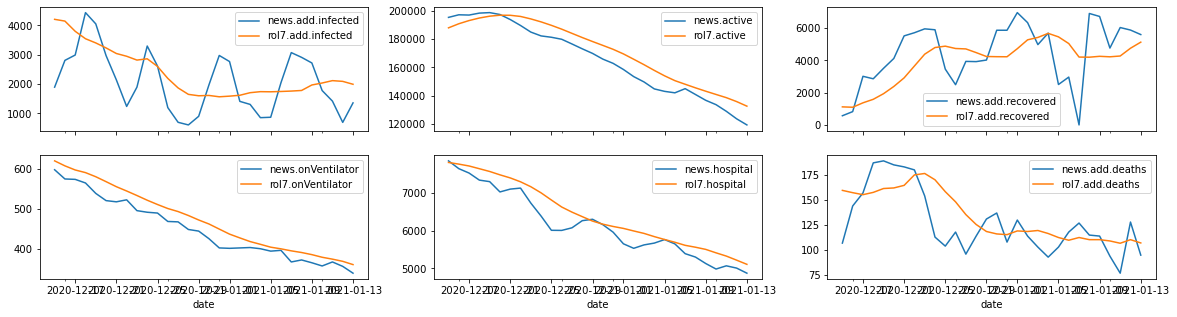

In [10]:
(fig, ax) = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharex=True)
plot_df = selected_details_df
configuration = {
    "add.infected":(0, 0), "onVentilator":(1,0),   # 1st col
    "active":(0,1),        "hospital":(1,1),       # 2nd col
    "add.recovered":(0,2), "add.deaths":(1,2)      # 3rd col
}
for category in configuration:
    plot_df["rol7.{}".format(category)] = plot_df.rolling(7).mean()[["news.{}".format(category)]]
plot_df = plot_df.reset_index().tail(30)

for (category, position) in configuration.items():
    my_ax = ax[position[0]][position[1]]
    plot_df.plot(x="date", y="news.{}".format(category), ax=my_ax)
    plot_df.plot(x="date", y="rol7.{}".format(category), ax=my_ax)
plt.show()

In [11]:
#plot_df["add.infected"] = plot_df.apply(lambda row: plot_df[plot_df["date"]<], axis=1)
#plot_df.head()
plot_df.tail(10)

,date,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,rol7.add.infected,rol7.onVentilator,rol7.active,rol7.hospital,rol7.add.recovered,rol7.add.deaths
304,2021-01-04,856.0,93.0,328851,174070.0,400.0,5667.0,144804.0,5689.0,1740.285714,411.000000,157893.571429,5838.857143,5675.142857,116.571429
305,2021-01-05,870.0,103.0,329721,176576.0,394.0,5760.0,143065.0,2506.0,1735.714286,403.857143,154058.000000,5762.000000,5458.714286,112.571429
306,2021-01-06,2047.0,118.0,331768,179541.0,396.0,5646.0,142029.0,2965.0,1746.428571,399.714286,150650.714286,5689.285714,5043.857143,109.857143
307,2021-01-07,3068.0,127.0,334836,179541.0,367.0,5387.0,144970.0,0.0,1760.285714,394.714286,148092.857143,5608.000000,4205.571429,112.571429
308,2021-01-08,2907.0,115.0,337743,186449.0,372.0,5297.0,140854.0,6908.0,1780.714286,390.571429,145565.142857,5557.857143,4198.000000,110.428571
309,2021-01-09,2716.0,114.0,340459,193172.0,365.0,5126.0,136733.0,6723.0,1967.285714,385.285714,143169.285714,5500.285714,4252.714286,110.428571
310,2021-01-10,1778.0,94.0,342237,197936.0,357.0,4980.0,133653.0,4764.0,2034.571429,378.714286,140872.571429,5409.000000,4222.142857,109.142857
311,2021-01-11,1419.0,77.0,343656,203972.0,367.0,5065.0,128959.0,6036.0,2115.000000,374.000000,138609.000000,5323.000000,4271.714286,106.857143
312,2021-01-12,696.0,128.0,344352,209852.0,356.0,5005.0,123647.0,5880.0,2090.142857,368.571429,135835.000000,5215.142857,4753.714286,110.428571
313,2021-01-13,1358.0,95.0,345710,215453.0,339.0,4870.0,119309.0,5601.0,1991.714286,360.428571,132589.285714,5104.285714,5130.285714,107.142857


In [12]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
# Convert date column and add week/dayofweek
baseDf['date'] =  pd.to_datetime(baseDf['date'], format='%Y-%m-%d')
baseDf[baseDf["date"].isin(["2020-12-01","2020-12-02","2020-12-03","2020-12-04","2020-12-05"])].pivot(
    index="region",
    columns="date",
    values="confirmed"
)

date,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05
region,,,,,
Baranya,5966,6083,6233,6423,6612
Borsod-Abaúj-Zemplén,13496,13733,14098,14387,14604
Budapest,47340,47985,48746,49680,50786
Bács-Kiskun,9719,9908,10177,10534,10759
Békés,6659,6811,7129,7429,7654
Csongrád,9360,9593,9966,10227,10462
Fejér,7469,7579,7859,8098,8279
Győr-Moson-Sopron,14384,14593,14917,15201,15479
Hajdú-Bihar,11900,12122,12544,12992,13335
